In [1]:
import torch

from diffusers import AutoencoderKL, DiffusionPipeline, LCMScheduler, StableDiffusionXLPipeline, UNet2DConditionModel
from PIL import Image

def load_pipe(use_dpo: bool = False) -> DiffusionPipeline:
    vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
    unet_params = {}
    if use_dpo:
        unet_params = {"unet": UNet2DConditionModel.from_pretrained(
            "mhdang/dpo-sdxl-text2image-v1", subfolder="unet", torch_dtype=torch.float16
        )}
    pipe = StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        vae=vae,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
        **unet_params
    )
    pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl", adapter_name="lcm")
    pipe.set_adapters(["lcm"], adapter_weights=[1.0])
    pipe.enable_model_cpu_offload()
    pipe.enable_vae_tiling()
    pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
    return pipe

pipe = load_pipe(False)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [2]:
from datasets import load_dataset
ds = load_dataset("yuvalkirstain/pickapic_v2", split="validation_unique", streaming=True)

Resolving data files:   0%|          | 0/645 [00:00<?, ?it/s]

In [ ]:
for i, entry in enumerate(iter(ds)):
    prompt = entry['caption']
    image = pipe(prompt, guidance_scale=1.5, num_inference_steps=4).images[0]
    image.save(f'./sdxl_output/sdxl_lcm_lora_out_{i:03d}.png')

In [ ]:
import torch

from diffusers import AutoencoderKL, DiffusionPipeline, LCMScheduler, StableDiffusionXLPipeline, UNet2DConditionModel
from PIL import Image

def load_pipe(use_dpo: bool = False) -> DiffusionPipeline:
    vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
    unet_params = {}
    if use_dpo:
        unet_params = {"unet": UNet2DConditionModel.from_pretrained(
            "mhdang/dpo-sdxl-text2image-v1", subfolder="unet", torch_dtype=torch.float16
        )}
    pipe = StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        vae=vae,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
        **unet_params
    )
    pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl", adapter_name="lcm")
    pipe.set_adapters(["lcm"], adapter_weights=[1.0])
    pipe.enable_model_cpu_offload()
    pipe.enable_vae_tiling()
    pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
    return pipe

pipe = load_pipe(True)

In [ ]:
for i, entry in enumerate(iter(ds)):
    prompt = entry['caption']
    image = pipe(prompt, guidance_scale=1.5, num_inference_steps=4).images[0]
    image.save(f'./dpo_output/dpo_lcm_lora_out_{i:03d}.png')

In [22]:
from transformers import AutoProcessor, AutoModel
from PIL import Image
import torch

# load model
device = "cuda"
processor_name_or_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_pretrained_name_or_path = "yuvalkirstain/PickScore_v1"

processor = AutoProcessor.from_pretrained(processor_name_or_path)
# model = AutoModel.from_pretrained(model_pretrained_name_or_path).eval().to(device)
model = AutoModel.from_pretrained(processor_name_or_path).eval().to(device)

def calc_probs(prompt, images):
    
    # preprocess
    image_inputs = processor(
        images=images,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)
    
    text_inputs = processor(
        text=prompt,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)


    with torch.inference_mode():
        # embed
        image_embs = model.get_image_features(**image_inputs)
        image_embs = image_embs / torch.norm(image_embs, dim=-1, keepdim=True)
    
        text_embs = model.get_text_features(**text_inputs)
        text_embs = text_embs / torch.norm(text_embs, dim=-1, keepdim=True)

        # score
        scores = model.logit_scale.exp() * (text_embs * image_embs).sum(-1)
    
    return scores.cpu().tolist()


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

In [18]:
from PIL import Image
import numpy as np
from tqdm import tqdm

sdxl_pickscores, dpo_pickscores = [], []
ds_iter = iter(ds)
prompts, sdxl_images, dpo_images = [], [], []

for i in tqdm(range(500)):
    prompts.append(next(ds_iter)['caption'])
    with open(f'./sdxl_outputs/sdxl_lcm_lora_out_{i:03d}.png', 'rb') as f:
        sdxl_images.append(Image.open(f).convert("RGB"))
    with open(f'./dpo_outputs/dpo_lcm_lora_out_{i:03d}.png', 'rb') as f:
        dpo_images.append(Image.open(f).convert("RGB"))
    if i % 32 == 31 or i == 499:
        sdxl_pickscores.extend(calc_probs(prompts, sdxl_images))
        dpo_pickscores.extend(calc_probs(prompts, dpo_images))
        prompts, sdxl_images,dpo_images = [], [], []

print(np.median(sdxl_pickscores))
print(np.median(dpo_pickscores))

100%|██████████| 500/500 [01:30<00:00,  5.54it/s]

21.64774513244629
21.917271614074707


In [21]:
np.sum(np.array(dpo_pickscores) - np.array(sdxl_pickscores) > 0) / 500

0.652

In [23]:
from PIL import Image
import numpy as np
from tqdm import tqdm

sdxl_clipscores, dpo_clipscores = [], []
ds_iter = iter(ds)
prompts, sdxl_images, dpo_images = [], [], []

for i in tqdm(range(500)):
    prompts.append(next(ds_iter)['caption'])
    with open(f'./sdxl_outputs/sdxl_lcm_lora_out_{i:03d}.png', 'rb') as f:
        sdxl_images.append(Image.open(f).convert("RGB"))
    with open(f'./dpo_outputs/dpo_lcm_lora_out_{i:03d}.png', 'rb') as f:
        dpo_images.append(Image.open(f).convert("RGB"))
    if i % 32 == 31 or i == 499:
        sdxl_clipscores.extend(calc_probs(prompts, sdxl_images))
        dpo_clipscores.extend(calc_probs(prompts, dpo_images))
        prompts, sdxl_images,dpo_images = [], [], []

print(np.median(sdxl_clipscores))
print(np.median(dpo_clipscores))

100%|██████████| 500/500 [01:29<00:00,  5.58it/s]

36.02571487426758
36.61895751953125


In [ ]:
ls

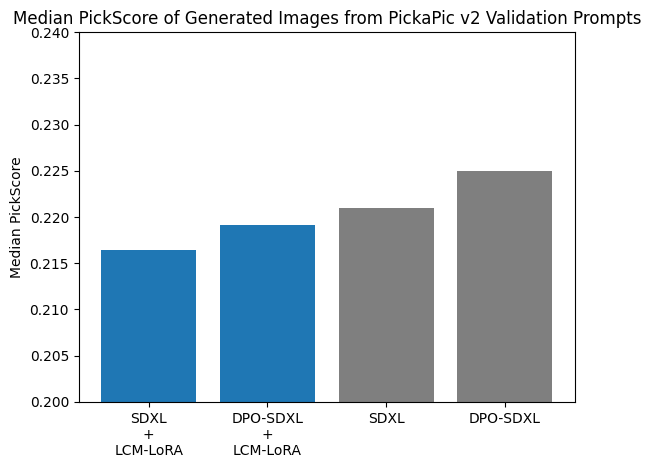

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['SDXL\n+\nLCM-LoRA', 'DPO-SDXL\n+\nLCM-LoRA', 'SDXL', 'DPO-SDXL']
counts = [0.2164774513244629, 0.21917271614074707, 0.221, 0.225]
bar_colors = ['tab:blue', 'tab:blue', 'tab:grey', 'tab:grey']
ax.bar(fruits, counts, color=bar_colors)

ax.set_ylabel('Median PickScore')
ax.set_ylim(0.20, 0.24)
ax.set_title('Median PickScore of Generated Images from PickaPic v2 Validation Prompts')

plt.show()
fig.savefig('pickapic.jpg')

In [24]:
np.sum(np.array(dpo_clipscores) - np.array(sdxl_clipscores) > 0) / 500

0.59

In [3]:
ds_iter = iter(ds)

@torch.inference_mode()
def eval_reward_gap(prompt, image):
    batch_size = len(prompt)
    device = pipe._execution_device

    # 3. Encode input prompt
    (
        prompt_embeds,
        negative_prompt_embeds,
        pooled_prompt_embeds,
        negative_pooled_prompt_embeds,
    ) = pipe.encode_prompt(
        prompt=prompt,
        prompt_2=prompt,
        device=device,
        num_images_per_prompt=10,
        do_classifier_free_guidance=True,
        negative_prompt=None,
        negative_prompt_2=None,
    )
    
    # 4. Preprocess image
    image = pipe.image_processor.preprocess(image).to(device, dtype=pipe.vae.dtype)
    print(image.shape)
    init_latents = pipe.vae.encode(image).latent_dist.sample() * pipe.vae.config.scaling_factor
    init_latents = init_latents.repeat_interleave(10, dim=0)

    timesteps = torch.randint(
        pipe.scheduler.config.num_train_timesteps, (10,), device=device, dtype=torch.int64
    ).repeat(image.shape[0])

    # 6. Prepare latent variables

    noise = torch.randn_like(init_latents)
    noise_a, noise_b = noise.chunk(2)
    # get latents
    latents = pipe.scheduler.add_noise(init_latents, noise, timesteps)
        
    original_size = target_size = (512, 512)
    crops_coords_top_left = (0, 0)
    aesthetic_score = 6.5
    negative_aesthetic_score = 2.5
    
    add_text_embeds = pooled_prompt_embeds
    if pipe.text_encoder_2 is None:
        text_encoder_projection_dim = int(pooled_prompt_embeds.shape[-1])
    else:
        text_encoder_projection_dim = pipe.text_encoder_2.config.projection_dim
    
    add_time_ids = pipe._get_add_time_ids(
        original_size=original_size,
        crops_coords_top_left=crops_coords_top_left,
        target_size=target_size,
        dtype=prompt_embeds.dtype,
        text_encoder_projection_dim=text_encoder_projection_dim,
    )
    add_time_ids = add_time_ids.repeat(batch_size * 10, 1)

    prompt_embeds = prompt_embeds.to(device)
    add_text_embeds = add_text_embeds.to(device)
    add_time_ids = add_time_ids.to(device)
    
    latent_model_input = pipe.scheduler.scale_model_input(latents, timesteps)

    # predict the noise residual
    added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
    noise_pred = pipe.unet(
        latent_model_input,
        timesteps,
        encoder_hidden_states=prompt_embeds,
        added_cond_kwargs=added_cond_kwargs,
        return_dict=False,
    )[0]
    noise_pred_a, noise_pred_b = noise_pred.chunk(2)
    pipe.maybe_free_model_hooks()
    return (((noise_a - noise_pred_a) ** 2).mean(0).sum() - ((noise_b - noise_pred_b) ** 2).mean(0).sum()).cpu().numpy()

In [4]:
import io
entry = next(ds_iter)

ds_iter = iter(ds)
prompt = [entry['caption']] * 2
image_0 = Image.open(io.BytesIO(entry['jpg_0']))
image_1 = Image.open(io.BytesIO(entry['jpg_1']))
reward = eval_reward_gap(prompt, [image_0, image_1])

torch.Size([2, 3, 768, 768])


In [5]:
reward

array(16., dtype=float16)

In [6]:
pipe.unet = UNet2DConditionModel.from_pretrained(
    "mhdang/dpo-sdxl-text2image-v1", subfolder="unet", torch_dtype=torch.float16
)
reward_dpo = eval_reward_gap(prompt, [image_0, image_1])
reward_dpo - reward

unet/config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:983: UserWarning: Not enough free disk space to download the file. The expected file size is: 10270.08 MB. The target location /root/.cache/huggingface/hub only has 5423.93 MB free disk space.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:983: UserWarning: Not enough free disk space to download the file. The expected file size is: 10270.08 MB. The target location /root/.cache/huggingface/hub/models--mhdang--dpo-sdxl-text2image-v1/blobs only has 5423.93 MB free disk space.
  warnings.warn(


diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

OSError: mhdang/dpo-sdxl-text2image-v1 does not appear to have a file named diffusion_pytorch_model.bin.

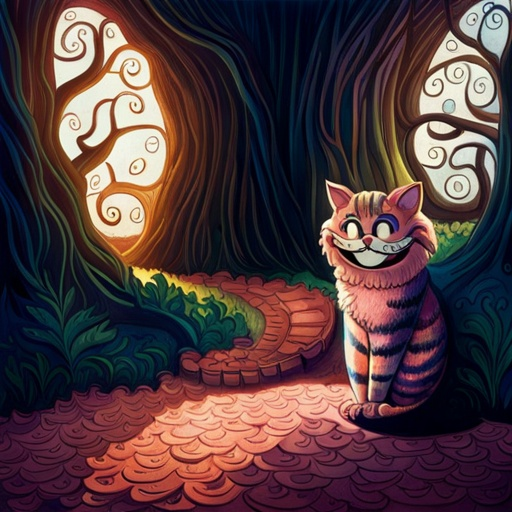

In [29]:
import io

from diffusers import EulerDiscreteScheduler

for i in tqdm(range(500)):
    entry = next(ds_iter)
    prompts.append(entry['caption'])
    image_0.append(Image.open(io.BytesIO(entry['jpg_0'])))
    image_1.append(Image.open(io.BytesIO(entry['jpg_1'])))
    with open(f'./sdxl_outputs/sdxl_lcm_lora_out_{i:03d}.png', 'rb') as f:
        sdxl_images.append(Image.open(f).convert("RGB"))
    with open(f'./dpo_outputs/dpo_lcm_lora_out_{i:03d}.png', 'rb') as f:
        dpo_images.append(Image.open(f).convert("RGB"))
    if i % 32 == 31 or i == 499:
        sdxl_pickscores.extend(calc_probs(prompts, sdxl_images))
        dpo_pickscores.extend(calc_probs(prompts, dpo_images))
        prompts, sdxl_images,dpo_images = [], [], []

